In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from collections import OrderedDict

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("false_data.csv") # dataset

In [ ]:
df.head() # headers of dataset

,itemid,username,userid,ctime,rating,comment,fakeornot,confidence level
0,22340582157,QuantumPioneer,99459455,1697178885,5,These Jordans are like walking on clouds—comfo...,fake,0
1,22340582157,NebulaNomad,446791504,1694277833,4,The attention to detail in these shoes is impe...,fake,0
2,22340582157,CipherCrafter,117767259,1691335952,3,The iconic Jumpman logo just adds that extra f...,fake,0
3,22340582157,ZephyrZenith,110405627,1692960752,4,"As a collector, these are a must-have in my sn...",fake,0
4,22340582157,LunarLabyrinth,473727562,1698291155,3,The quality of materials used makes these Jord...,fake,0


In [4]:
df.isna().sum() # look for None values and delete them

itemid              0
username            0
userid              0
ctime               0
rating              0
comment             0
fakeornot           0
confidence level    0
dtype: int64

In [5]:
df['comment'] = df.apply(lambda row: str(row['comment']).lower(), axis=1) # lowercase
tokenizer = RegexpTokenizer(r'\w+')
df['comment'] = df['comment'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x))) # remove punctuation but word tokenization


In [6]:
df['review_length'] = df['comment'].apply(lambda x: len(x.split())) # review word count

In [7]:
df['date'] = pd.to_datetime(df['ctime'],unit='s').dt.date #date column
df['time'] = pd.to_datetime(df['ctime'],unit='s').dt.time # time column

In [8]:
mnr_df1 = df[['userid', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'userid']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max() #finds the number of reviews made in 1 day/number of reviews ever made by this user
df = df.merge(mnr_df2, on=['userid', 'date'], how='inner')

In [9]:
review_data = df
res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].userid in res:
        res[row[1].userid].append(row[1].comment) #add comment to existing user
    else:
        res[row[1].userid] = [row[1].comment] # new user

individual_reviewer = [{'userid': k, 'comment': v} for k, v in res.items()]
df2 = dict()
df2['userid'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['comment'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just 1 review
    if max == -np.inf:
        max = 0
    df2['userid'][count] = reviewer_data['userid']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['userid', 'Maximum Content Similarity'])
df = pd.merge(review_data, df3, on="userid", how="left")
df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True) #merge df and df3

df.drop(['itemid', 'userid', 'username', 'ctime', 'rating', 'comment'], axis=1, inplace=True) # remove anything that is not relevant


<ipython-input-9-8f0a8080c8b4>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['userid'] = pd.Series([])
<ipython-input-9-8f0a8080c8b4>:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


In [ ]:
df.head()

,fakeornot,confidence level,review_length,date,time,mnr,Maximum Content Similarity
0,fake,0,10,2023-10-13,06:34:45,0.5,0.0
1,fake,0,12,2023-09-09,16:43:53,0.5,0.0
2,fake,0,12,2023-08-06,15:32:32,0.5,0.0
3,fake,0,12,2023-08-25,10:52:32,0.5,0.0
4,fake,0,13,2023-10-26,03:32:35,0.5,0.0


In [10]:
X = df[['review_length', 'mnr', 'Maximum Content Similarity']]
y = df['fakeornot']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42) #dataset training

In [12]:
c_val = [0.75, 1, 2, 3, 4, 5, 10]

for c in c_val:
    logreg = LogisticRegression(C=c)
    logreg.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, logreg.predict(X_test))))

Accuracy for C=0.75: 0.8032786885245902
Accuracy for C=1: 0.8688524590163934
Accuracy for C=2: 0.9344262295081968
Accuracy for C=3: 0.9344262295081968
Accuracy for C=4: 0.9262295081967213
Accuracy for C=5: 0.9262295081967213
Accuracy for C=10: 0.9262295081967213


In [13]:
confusionMatrix = confusion_matrix(y_test, logreg.predict(X_test)) #TN FP FN TP
confusionMatrix

array([[17,  8],
       [ 1, 96]])

<Axes: xlabel='Predicted', ylabel='Actual'>

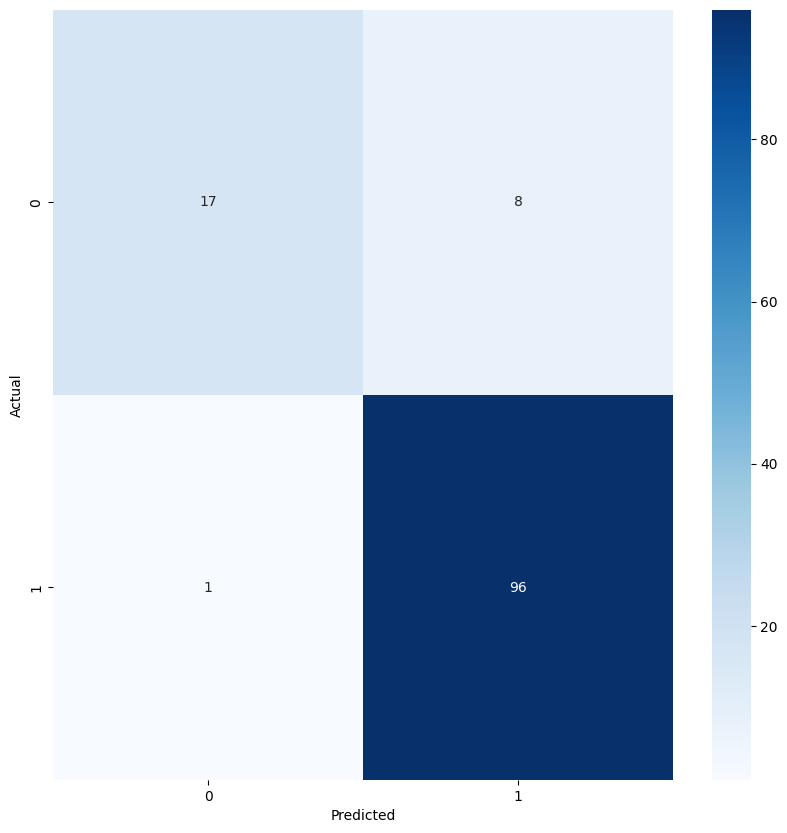

In [15]:
confusionMatrix = pd.DataFrame(confusionMatrix, index=[0,1], columns=[0,1])
confusionMatrix.index.name = 'Actual'
confusionMatrix.columns.name = 'Predicted'

plt.figure(figsize = (10,10))
sns.heatmap(confusionMatrix, cmap= "Blues",annot = True, fmt='')

In [16]:
predicted = logreg.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test, predicted)))
print('Precision Score : ' + str(precision_score(y_test, predicted, pos_label="original")))
print('Recall Score : ' + str(recall_score(y_test, predicted, pos_label="original"))) #correctly predicted positive instances to all actual positive instances.
print('F1 Score : ' + str(f1_score(y_test, predicted, pos_label="original"))) #balance between precision and recall

Accuracy Score : 0.9262295081967213
Precision Score : 0.9230769230769231
Recall Score : 0.9896907216494846
F1 Score : 0.955223880597015


In [17]:
test = pd.read_csv("false_data.csv")

In [18]:
test['comment'] = test.apply(lambda row: str(row['comment']).lower(), axis=1)
# Preprocessing
# Remove Punctuations
tokenizer = RegexpTokenizer(r'\w+')
test['comment'] = test['comment'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))
# Feature Engineering
test['review_length'] = test['comment'].apply(lambda x: len(x.split()))

# Convert UNIX timestamp to date and time
test['date'] = pd.to_datetime(test['ctime'],unit='s').dt.date
test['time'] = pd.to_datetime(test['ctime'],unit='s').dt.time

# Maximum Number of Reviews per day per reviewer
mnr_df1 = test[['userid', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'userid']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
test = test.merge(mnr_df2, on=['userid', 'date'], how='inner')
# Cosine Similarity
review_data = test
res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].userid in res:
        res[row[1].userid].append(row[1].comment)
    else:
        res[row[1].userid] = [row[1].comment]

individual_reviewer = [{'userid': k, 'comment': v} for k, v in res.items()]
df2 = dict()
df2['userid'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['comment'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just one review
    if max == -np.inf:
        max = 0
    df2['userid'][count] = reviewer_data['userid']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['userid', 'Maximum Content Similarity'])
# left outer join on original datamatrix and cosine dataframe
test = pd.merge(review_data, df3, on="userid", how="left")
df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)

logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)

<ipython-input-18-9ac77adf95b2>:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['userid'] = pd.Series([])
<ipython-input-18-9ac77adf95b2>:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


LogisticRegression(C=10)

In [19]:
test['fakeornot'] = 'none' #changing fakeornot to none so can reassign
test.head()

,itemid,username,userid,ctime,rating,comment,fakeornot,confidence level,review_length,date,time,mnr,Maximum Content Similarity
0,22340582157,QuantumPioneer,99459455,1697178885,5,these jordans are like walking on clouds comfo...,none,0,10,2023-10-13,06:34:45,0.5,0.0
1,22340582157,NebulaNomad,446791504,1694277833,4,the attention to detail in these shoes is impe...,none,0,12,2023-09-09,16:43:53,0.5,0.0
2,22340582157,CipherCrafter,117767259,1691335952,3,the iconic jumpman logo just adds that extra f...,none,0,12,2023-08-06,15:32:32,0.5,0.0
3,22340582157,ZephyrZenith,110405627,1692960752,4,as a collector these are a must have in my sne...,none,0,12,2023-08-25,10:52:32,0.5,0.0
4,22340582157,LunarLabyrinth,473727562,1698291155,3,the quality of materials used makes these jord...,none,0,13,2023-10-26,03:32:35,0.5,0.0


In [31]:
# Assuming you have already trained a logistic regression model named logreg
# and you have a test set with features 'review_length', 'mnr', 'Maximum Content Similarity'

# Make predictions on the test set
y_pred = logreg.predict(test[['review_length', 'mnr', 'Maximum Content Similarity']])

# Assign the predicted labels to a new column 'fakeornot' in the test set
test['fakeornot'] = y_pred

# Obtain probability estimates for each class
probabilities = logreg.predict_proba(test[['review_length', 'mnr', 'Maximum Content Similarity']])

# Extract the probability of the positive class (class 1)
confidence_level = probabilities[:, 1]

# Add the confidence level to a new column 'confidence_level' in the test set
test['confidence level'] = confidence_level

[0.76296496 0.79231367 0.79231367 0.79231367 0.80594762 0.79231367
 0.76296496 0.81889113 0.80594762 0.80594762 0.77798569 0.16534832
 0.16534832 0.14320953 0.15395367 0.12359601 0.13309725 0.13309725
 0.15395367 0.14320953 0.12359601 0.13309725 0.14320953 0.12359601
 0.13309725 0.16534832 0.12359601 0.12359601 0.15395367 0.13309725
 0.17740947 0.13309725 0.17740947 0.12359601 0.14320953 0.13309725
 0.14320953 0.19014998 0.14320953 0.13309725 0.17740947 0.16534832
 0.1146833  0.75377756 0.73087762 0.74220039 0.76296496 0.71820413
 0.79231367 0.7770145  0.96162051 0.96162051 0.96742274 0.96742274
 0.96162051 0.96162051 0.96999664 0.96999664 0.97237299 0.97237299
 0.93769153 0.93769153 0.89250508 0.89250508 0.92103092 0.92103092
 0.99599052 0.99599052 0.99067284 0.99067284 0.99714244 0.99714244
 0.95483311 0.95483311 0.99275621 0.99275621 0.97658922 0.97658922
 0.96742274 0.96742274 0.97456605 0.97456605 0.96999664 0.96999664
 0.98799752 0.98799752 0.98580603 0.98580603 0.96742274 0.9674

In [32]:
test.head()

,itemid,username,userid,ctime,rating,comment,fakeornot,confidence level,review_length,date,time,mnr,Maximum Content Similarity,confidence_level
0,22340582157,QuantumPioneer,99459455,1697178885,5,these jordans are like walking on clouds comfo...,original,0.762965,10,2023-10-13,06:34:45,0.5,0.0,0.762965
1,22340582157,NebulaNomad,446791504,1694277833,4,the attention to detail in these shoes is impe...,original,0.792314,12,2023-09-09,16:43:53,0.5,0.0,0.792314
2,22340582157,CipherCrafter,117767259,1691335952,3,the iconic jumpman logo just adds that extra f...,original,0.792314,12,2023-08-06,15:32:32,0.5,0.0,0.792314
3,22340582157,ZephyrZenith,110405627,1692960752,4,as a collector these are a must have in my sne...,original,0.792314,12,2023-08-25,10:52:32,0.5,0.0,0.792314
4,22340582157,LunarLabyrinth,473727562,1698291155,3,the quality of materials used makes these jord...,original,0.805948,13,2023-10-26,03:32:35,0.5,0.0,0.805948


In [21]:
fake = test.fakeornot.str.count("fake").sum()
original = test.fakeornot.str.count("original").sum()

print(fake)
print(original)

33
210


In [ ]:
test['comment'].loc[(test.fakeornot == 'fake')]

11     true to size and fits like a glove no need to ...
12     i bought these for my son and he absolutely lo...
13     the retro vibe of these jordans is nostalgic a...
14     they look even better in person than in the pi...
15     you can t beat the timeless style of jordan sn...
16     i ve never received so many compliments on my ...
17     versatile enough to pair with any outfitâ casu...
18     the grip on these shoes is fantastic making th...
19     the packaging and unboxing experience are as p...
20     attention sneakerheads these are a must cop fo...
21     the leather is so soft it feels like a second ...
22     even after hours of wear my feet still feel co...
23     i love the limited edition colorway i snagged ...
24     these jordans add that extra edge to my street...
25     the arch support is on pointâ no more sore fee...
26     these are not just shoes they re a statement p...
27     i appreciate the commitment to sustainability ...
28     my basketball game has i

In [ ]:
test['comment'].loc[(test.fakeornot == 'original')]

0      these jordans are like walking on cloudsâ comf...
1      the attention to detail in these shoes is impe...
2      the iconic jumpman logo just adds that extra f...
3      as a collector these are a must have in my sne...
4      the quality of materials used makes these jord...
                             ...                        
238    2nd time buying bought it like yesterday i rec...
239    fast delivery item received well packed and in...
240    fast delivery and well pack with good conditio...
241    thank you up to my expectations and quick deli...
242       super fast delivery item looks great thank you
Name: comment, Length: 210, dtype: object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')